
# Creating Class Activation Atlases with captum.optim

This notebook demonstrates the use of the captum.optim submodule for creation of class specific [Activation Atlases](https://distill.pub/2019/activation-atlas/) for the InceptionV1 model imported from Caffe.

Activation atlases provide a big picture overview of how a model layer represents various concepts, by using samples from the manifold of likely activations. Activation atlases can also show us the relationships between concepts, and they make it possible to identify possible adversarial attacks.


In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import matplotlib.pyplot as plt

from captum.optim.models import googlenet

import captum.optim as opt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = googlenet(pretrained=True).to(device).eval()

We'll begin by defining some helper functions that will be explained in greater detail later on in the tutorial.

In [ ]:
from typing import List, Optional, Tuple, Union


def get_top_class_indices(attributions: torch.Tensor, class_idx: int) -> torch.Tensor:
    """
    Collect attribution indices where the top attributed class id is class_idx.

    Args:
        attributions (torch.Tensor): A set of attributions that correspond to a set of
            activation samples.
        class_idx (int): The target class id.
    Returns:
        indices (torch.Tensor): A set of indices for the top idx for the target class.
    """
    assert attributions.dim() == 2
    return torch.tensor(
        [
            i
            for i, attr in enumerate(attributions)
            if class_idx in torch.argsort(-attr)[0:1]
        ],
        device=attributions.device,
    )


def get_postive_class_indices(
    attributions: torch.Tensor, class_idx: int, num_indices: int
) -> torch.Tensor:
    """
    Collect indices for the top num_indices of positive class_idx attributions from
    the given set of attribution samples.

    Args:
        attributions (torch.Tensor): A set of attributions that correspond to a set
            of activation samples.
        class_idx (int): The target class id.
        num_indices (int): The number of top indices to collect.
    Returns:
        indices (torch.Tensor): A set of indices where the top idx is the target
            class.
    """
    assert attributions.dim() == 2
    indices = torch.argsort(-attributions[:, class_idx])[0:num_indices]
    positive = attributions[indices, class_idx] > 0
    return indices[positive]


def create_alpha_mask(
    h: int,
    w: int,
    coords: List[Union[Tuple[int, int, int], Tuple[int, int]]],
    device: torch.device = torch.device("cpu"),
) -> torch.tensor:
    """
    Create an alpha mask to make an activation atlas background transparent.

    Args:
       h (int): The height of each cell.
       w (int): the width of each cell.
       coords (List[Union[Tuple[int, int, int], Tuple[int, int]]]): A list of
           atlas coordinates to use for creating the mask.
       device (torch.device, optional): The device that the cells are on.
    Returns:
       alpha_mask (torch.Tensor): An alpha mask tensor used to make an atlas
           background transparent.
    """

    return opt.atlas.create_atlas(
        [torch.ones(1, 1, h, w, device=device) for n in coords],
        coords,
        grid_size=grid_size,
        base_tensor=torch.zeros,
    )

## Atlas Setup

Activation atlases are created by using randomly collected neuron activation samples from the dataset that the selected model was trained on.

Samples are collected by first randomly collecting a neuron activation sample with a shape of: `1, channels, 1, 1` for every image in the batch. We avoid edge neurons to improve activation atlas quality by only collecting neuron samples from between `[1, height -1]` and `[1, width -1]`. The neuron class attributions are then estimated by determining the rate at which increasing the neuron affects the output classes.

### Download Pre-collected Activations & Attributions

Before we can start the main tutorial, you'll first have to download a set of pre-collected activation and attribution samples for the Mixed5b ReLU layer of our model. For this tutorial we'll use the recommended number of 400,000 activation & attribution samples, but in practice any number of samples can be used (though more samples is always better). The sample attributions were collected using a relaxed version of our model where all of the `nn.MaxPool2d` layers were replaced with Captum's `MaxPool2dRelaxed` layer.

Both the activation samples and their corresponding attributions have a shape of `[n_samples, n_channels]`.

You can learn more about how to collect your own samples from the first [Activation Atlas tutorial](https://).

In [ ]:
fileurl = "https://pytorch-tutorial-assets.s3.amazonaws.com/captum/"

activation_samples = torch.hub.load_state_dict_from_url(
    url=fileurl + "inceptionv1_mixed5b_relu_samples_activations.pt",
    progress=True,
).to(device)

sample_attributions = torch.hub.load_state_dict_from_url(
    url=fileurl + "inceptionv1_mixed5b_relu_samples_attributions.pt",
    progress=True,
).to(device)

### Sample Filtering

To start things off, we'll first need to collect sample indices of interest from our activation samples. Unlike a normal activation atlas, we filter out activation sample indices based on their attribution strength for the target class. 

To collect the activation sample indices that we need, we will collect two sets of sample indices and then combine them together. The first set of sample indices: `class_indices`, are for samples where the top attributed class is our target class. If we only use the first set of sample indices, then we will create a class-specific activation atlas. However, it is often useful to include some highly related indices into our class activation atlases. To do this, we create a second set of sample indices: `positive_class_indices`, for samples with attributed classes that are highly related to the target class.

Below we only collect the samples that are related to scuba divers, but there are plenty of other classes to choose from.

In [ ]:
# Uncomment to print all 1000 model class ids and their corresponding classnames
# {print(str(v) + ":", k) for v, k in enumerate(opt.models.INCEPTION5H_CLASSES)}

In [ ]:
# 6 grey whale
# 62 red fox
# 76 tiger
# 442 great white shark
# 671 frying pan
# 672 wok
# 235 fireboat
# 287 streetcar
# 982 scuba diver
# 507 snorkel
# 547 abacus
# 643 monarch

class_id: int = 982  # selected class id
class_specific = False  # Change to True for class-specific atlas

class_indices = get_top_class_indices(sample_attributions, class_id)
if class_specific:
    selected_indices = class_indices
else:
    top_positive_class_indices = get_postive_class_indices(
        sample_attributions, class_id, num_indices=3000
    )
    selected_indices = torch.cat((class_indices, top_positive_class_indices), 0)

# Filter out nonselected activation samples
filtered_samples = activation_samples[selected_indices]

### Dimensionality Reduction For Activation Atlas Coordinate Grid Creation

After filtering our activation samples, we can use either [UMAP](https://umap-learn.readthedocs.io/en/latest/) or Sklearn's [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.mtanifold.TSNE.html) to reduce the number of channels to 2. By reducing the number of channels in our activation samples to 2, we turn the data in a grid of x and y coordinates that we can then graph and visualize!

In general t-SNE performs better than UMAP on sparse sample data like the y axis of multi class activation atlases. The UMAP alogrithm performs better on dense sample data for more general activation atlases.

**Reproducibility**

It is important to note that by default both UMAP and t-SNE introduce a bit of randomness into their results, and thus individual cells and the overall shape of the atlas will differ between runs. This is acceptable as we are mainly interested in the spatial relationships that emerge between concepts in the atlas.

In [ ]:
import umap

c_reducer = opt.reducer.ChannelReducer(
    n_components=2,
    reduction_alg=umap.UMAP,
    verbose=True,
    n_neighbors=20,
    min_dist=0.01,
    metric="cosine",
)
# You can also use TSNE instead of UMAP if desired:
# from sklearn.manifold import TSNE
# c_reducer = opt.reducer.ChannelReducer(
#    n_components=2,
#    reduction_alg=TSNE,
#    verbose=True,
#    metric="cosine",
#    learning_rate=10,
#    perplexity=50,
# )

xy_grid = c_reducer.fit_transform(filtered_samples.cpu()).to(device)

UMAP(a=None, angular_rp_forest=True, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='cosine', metric_kwds=None,
     min_dist=0.01, n_components=2, n_epochs=None, n_jobs=-1, n_neighbors=20,
     negative_sample_rate=5, output_dens=False, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, ...)
Construct fuzzy simplicial set
Fri Apr 30 19:18:07 2021 Finding Nearest Neighbors
Fri Apr 30 19:18:08 2021 Finished Nearest Neighbor Search
Fri Apr 30 19:18:08 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epoch

Now that we have our two dimensional grid of x and y coordinates for our reduced activation samples, we need to normalize it. We can use Captum.optim's `normalize_grid` function to both remove outliers and to rescale the values of our graph to between 0 and 1.

In [ ]:
# Normalize xy_grid for graphing
normalized_xy_grid = opt.atlas.normalize_grid(xy_grid)

After normalizing the xy grid, it is possible to plot the results using a graphing library like `matplotlib`. The shape of the plotted graph will be the same shape as the full activation atlas!

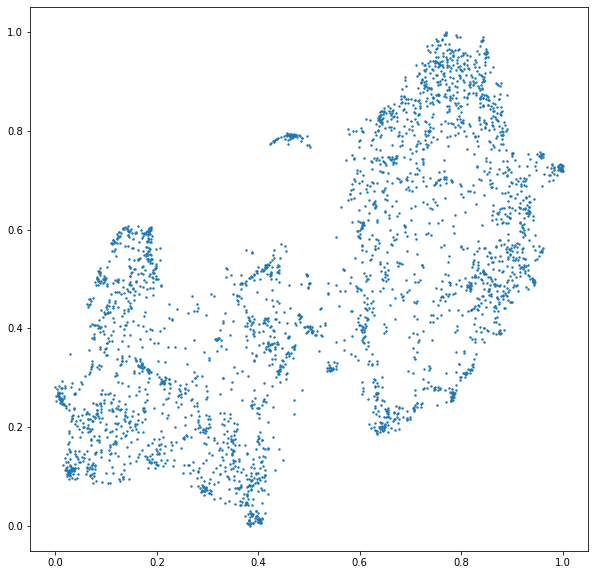

In [ ]:
# Show the normalized xy coordinate grid
plt.figure(figsize=(10, 10))
plt.scatter(x=normalized_xy_grid[:, 0].cpu(), y=normalized_xy_grid[:, 1].cpu(), s=2)
plt.show()

## Activation Atlas Vectors & Coordinates

Now we can use both the filtered activation samples and our xy coordinate grid to create the direction vectors that are required for rendering the atlas visualizations. To create the direction vectors we will used Captum.optim's `create_atlas_vectors` function:

* The `xy_grid` parameter is our xy coordinate grid.
* The `raw_activations` parameter is for the raw activation samples (that can optionally be filtered beforehand).
* The `grid_size` parameter defines how big our atlas should be, with the number of visualizations for each dimension in the form of: (`width, height`).
* The `min_density` parameter specifies the minimum number of sample points a cell requires to be counted.
* The `normalize` parameter determines whether `xy_grid` requires normalization.

The `create_atlas_vectors` function will return a set of direction vectors and a list of corresponding coordinations for creating the final activation atlas image. Each set of coordinates will also contain the number of samples that were used to create the direction at that position.

While choosing a `grid_size` is completely arbitrary, choosing the wrong grid size can result in important concepts being hidden in the averages.

In [ ]:
grid_size = (8, 8)
min_density = 4
vecs, vec_coords = opt.atlas.create_atlas_vectors(
    xy_grid=normalized_xy_grid,
    raw_activations=filtered_samples,
    grid_size=grid_size,
    min_density=min_density,
    normalize=False,  # Don't run normalize_grid as we already did it above
)

### Activation Atlas Shape

Using the atlas coordinates we created above, we can easily see the shape of our atlas before rendering all of the images. We'll explain the `create_atlas` function in greater detail further down.

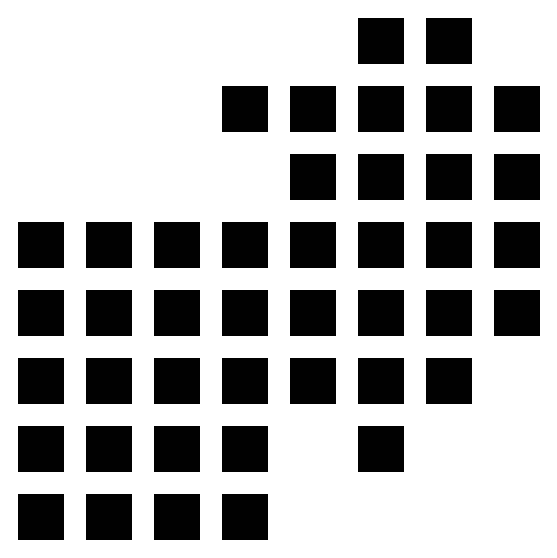

In [ ]:
import torch.nn.functional as F

# Create black & white atlas
atlas_bw_tensors = [
    F.pad(torch.ones(1, 3, 4, 4) * 255, (1, 1, 1, 1), value=1) for n in vec_coords
]
atlas_bw = opt.atlas.create_atlas(
    atlas_bw_tensors, vec_coords, grid_size=grid_size
)

# Make background transparent
alpha_bw_mask = create_alpha_mask(6, 6, coords=vec_coords, device=atlas_bw.device)
atlas_bw = torch.cat([atlas_bw, alpha_bw_mask], 1)

opt.images.show(atlas_bw, figsize=(10, 10))

## Rendering The Activation Atlas Visualizations

Now we should have everything we need to start rendering the visualizations for each activation atlas cell!

To create the visualizations for our atlas we will use the `AngledNeuronDirection` objective, which places more emphasis on angle than the default direction objectives. We'll also make use of Captum.optim's batch targeting feature to greatly speed up rendering!

In [ ]:
def vis_neuron_direction(
    model: torch.nn.Module,
    target: torch.nn.Module,
    vecs: torch.Tensor,
    vec_whitened: Optional[torch.Tensor] = None,
) -> Tuple[torch.Tensor, torch.Tensor]:
    image = opt.images.NaturalImage((80, 80), batch=vecs.shape[0]).to(device)
    loss_fn_list = [
        opt.loss.AngledNeuronDirection(
            target, vec, vec_whitened, cossim_pow=4.0, batch_index=i
        )
        for i, vec in enumerate(vecs)
    ]
    loss_fn = sum(loss_fn_list)

    transforms = torch.nn.Sequential(
        opt.transforms.RandomSpatialJitter(4),
        opt.transforms.RandomSpatialJitter(4),
        opt.transforms.RandomSpatialJitter(8),
        opt.transforms.RandomSpatialJitter(8),
        opt.transforms.RandomSpatialJitter(8),
        opt.transforms.RandomScale(
            scale=[0.995 ** n for n in range(-5, 80)]
            + [0.998 ** n for n in 2 * list(range(20, 40))]
        ),
        opt.transforms.RandomRotation(
            degrees=list(range(-20, 20))
            + list(range(-10, 10))
            + list(range(-5, 5))
            + 5 * [0]
        ),
        opt.transforms.RandomSpatialJitter(2),
    )
    obj = opt.InputOptimization(model, loss_fn, image, transforms)
    history = obj.optimize(opt.optimization.n_steps(512, True), lr=0.01)

    # Collect the final loss values separately for each batch element
    final_activations = opt.models.collect_activations(model, target, image().detach())
    final_losses = torch.stack([l(final_activations).mean() for l in loss_fn_list])

    return image(), final_losses

Next we whiten the raw unfiltered Mixed5b ReLU activation samples to help unstretch the activation space for the `AngledNeuronDirection` objective.

In [ ]:
# Whiten the raw activations
whitend_activation_samples = torch.inverse(
    torch.matmul(activation_samples.T, activation_samples)
    / len(activation_samples)
)

Now we can render all the previously calculated direction vectors! To maximize atlas quality, we can optionally try rendering multiple attempts of each atlas cell visualization and then keeping the attempt with the lowest final loss value (closest to zero).

In [ ]:
num_attempts = 2

attempts, attempt_losses = [], []
for a in range(num_attempts):
    if num_attempts > 1:
        print("Attempt: {} / {} ".format(a + 1, num_attempts))

    imgs, losses = vis_neuron_direction(
        model, model.mixed5b_relu, vecs=vecs, vec_whitened=whitend_activation_samples
    )
    attempts.append(imgs.detach().cpu())
    attempt_losses.append(losses)

A = []
attempt_losses = torch.stack(attempt_losses)
for i in range(vecs.shape[0]):
    idx = torch.argmax(attempt_losses[:,i])
    A.append(attempts[idx][i].unsqueeze(0))

Now we can put all the newly rendered images together using the cell coordinates that we previously calculated!

To put the rendered atlas cells together, we'll use the `create_atlas` function. The `create_atlas` takes the following inputs and returns a complete atlas in the form of a tensor:

* `cells`: A list of NCHW image tensors that are all the same shape, or a set of NCHW image tensors stacked along the batch dimension.

* `coords`: A list of coordinates that correspond to the inputs to `cells`.

* `grid_size` The same grid size that was used to create the atlas visualizations and coordinates.

The resulting atlas will match the number of channels used in the input cells. Thus, this flexibility of the `create_atlas` function allows us to do things like create a alpha transparency mask in order to make the background transparent!

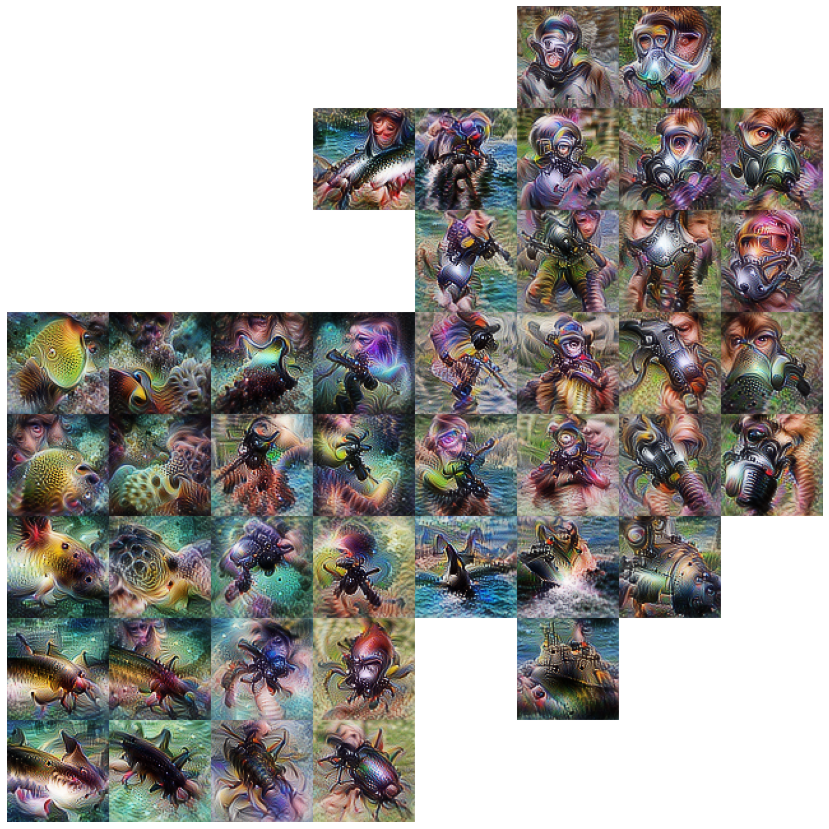

In [ ]:
atlas_img = opt.atlas.create_atlas(A, vec_coords, grid_size=grid_size)

# Make background transparent
alpha_mask = create_alpha_mask(
    *A[0].shape[2:], coords=vec_coords, device=atlas_img.device
)
atlas_img = torch.cat([atlas_img, alpha_mask], 1)

# Save atlas as image and show it to user
opt.images.save_tensor_as_image(atlas_img.detach(), "class_atlas_" + str(class_id) + ".png")
opt.images.show(atlas_img.detach(), figsize=(15, 15))

# Multi Class Activation Atlases

While it can be useful to visualize the activation atlas of a single class, sometimes we want to compare two different classes.

Now let's compare two classes!

In [ ]:
class_specific = False  # Change to True for class-specific atlas

# snorkel
class_id_one = 507
class_indices = get_top_class_indices(sample_attributions, class_id_one)
if class_specific:
    selected_indices_one = class_indices
else:
    top_positive_class_indices = get_postive_class_indices(
        sample_attributions, class_id_one, 3000
    )
    selected_indices_one = torch.cat((class_indices, top_positive_class_indices), 0)

# scuba diver
class_id_two = 982
class_indices = get_top_class_indices(sample_attributions, class_id_two)
if class_specific:
    selected_indices_two = class_indices
else:
    top_positive_class_indices = get_postive_class_indices(
        sample_attributions, class_id_two, 3000
    )
    selected_indices_two = torch.cat((class_indices, top_positive_class_indices), 0)

selected_indices = torch.cat((selected_indices_one, selected_indices_two), 0)

# Filter out nonselected samples
filtered_samples = activation_samples[selected_indices]
filtered_attributions = sample_attributions[selected_indices]

We'll use TSNE instead of UMAP and reduce the number of channels down to 1. This will give us the y-axis of our graph. 

In [ ]:
from sklearn.manifold import TSNE
c_reducer_tsne = opt.reducer.ChannelReducer(
    n_components=1,
    reduction_alg=TSNE,
    verbose=False,
    metric="cosine",
    learning_rate=10,
    perplexity=50,
)

y_grid = c_reducer_tsne.fit_transform(filtered_samples.cpu()).to(device)

Next we use the filtered attributions to create our x-axis, and then we stack them on top of the y-axis that we created above. This will give us a graph with visualization similarity on one axis, and the class differences on the other axis.

In [ ]:
# Calculate x-axis based on attribution difference
x_grid = (
    filtered_attributions[:, class_id_two] - filtered_attributions[:, class_id_one]
)

# Normalize the x-axis to between -1.0 and 1.0
x_grid = torch.clamp(x_grid / torch.quantile(x_grid.abs(), 0.99, dim=0), -1, 1)

# Normalize the y axis to between 0.0 and 1.0
y_grid = opt.atlas.normalize_grid(y_grid)[:, 0]

# Stack x and y axes
xy_grid = torch.stack([x_grid, y_grid], 0).permute(1, 0)

We can now plot our newly created xy coordinate graph if we wish to like so:

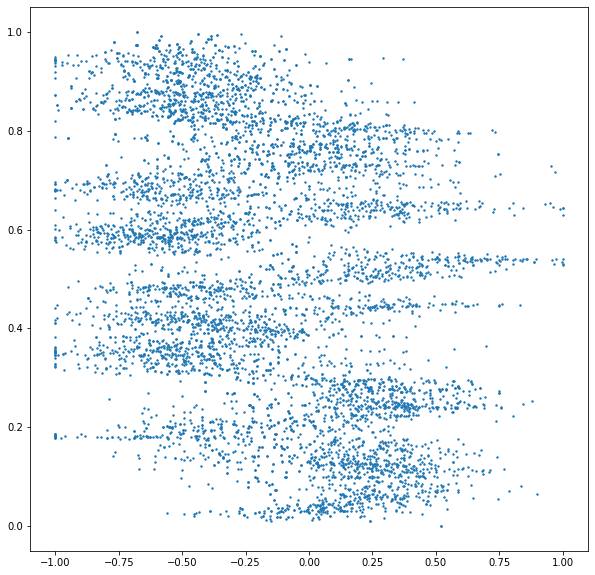

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(x=x_grid.cpu(), y=y_grid.cpu(), s=2)
plt.show()

## Multi Class Activation Atlas Vectors & Coordinates 

Below we setup our activation vectors and their atlas coordinates, using the xy grid that we created above and the corresponding filtered activation samples. Note that the x-axis of the graph above has a range of `[-1, 1]`, and thus we must make sure to change the `x_extent` to match.

In [ ]:
grid_size = (10, 10)
min_density = 4
vecs, vec_coords = opt.atlas.create_atlas_vectors(
    xy_grid=xy_grid,
    raw_activations=filtered_samples,
    grid_size=grid_size,
    min_density=min_density,
    x_extent=(-1.0, 1.0),
    normalize=False,  # Don't run normalize_grid as we already did it above
)

## Creating The Multi Class Activation Atlas Visualizations

Now we can render all the previously calculated multi class direction vectors. Like before, we can maximize atlas quality by making multiple rendering attempts for each atlas cell. We then select the rendering attempt with the lowest final loss value (closest to zero).

In [ ]:
num_attempts = 2

attempts, attempt_losses = [], []
for a in range(num_attempts):
    if num_attempts > 1:
        print("Attempt: {} / {} ".format(a + 1, num_attempts))

    imgs, losses = vis_neuron_direction(
        model, model.mixed5b_relu, vecs=vecs, vec_whitened=whitend_activation_samples
    )
    attempts.append(imgs.detach().cpu())
    attempt_losses.append(losses)

B = []
attempt_losses = torch.stack(attempt_losses)
for i in range(vecs.shape[0]):
    idx = torch.argmax(attempt_losses[:,i])
    B.append(attempts[idx][i].unsqueeze(0))

Now we can put all the images together using the visualizations that we created and their atlas coordinates! The left side is most strongly attributed to the snorkel class, and the right side is most strongly attributed to the scuba diver class. On the vertical axis, cells are sorted based on the one-dimensional TSNE similarity that we calculated above.




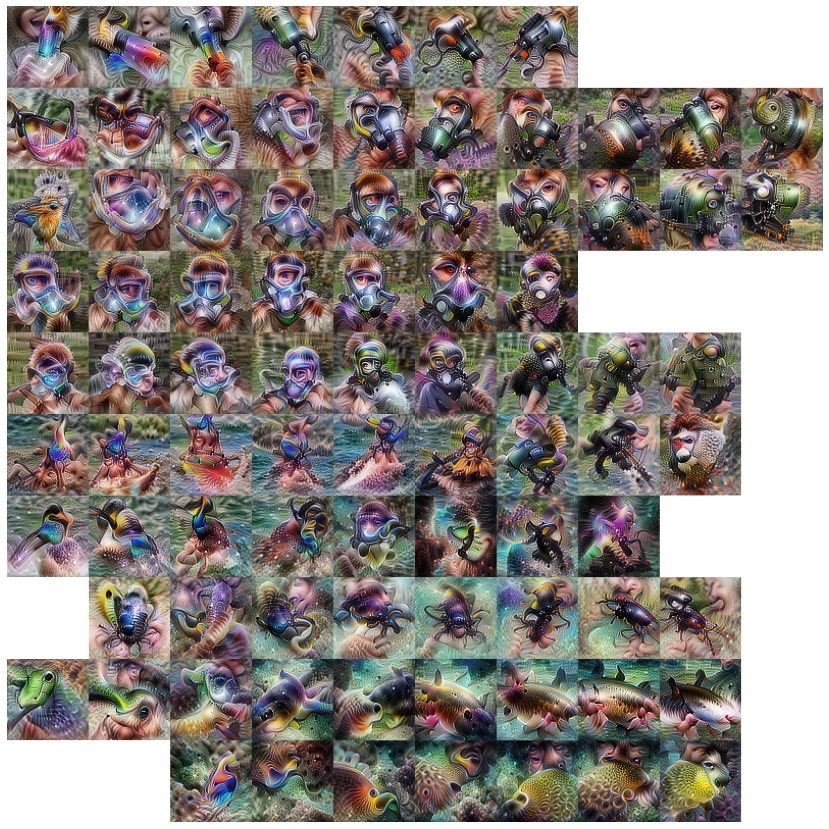

In [ ]:
atlas_img = opt.atlas.create_atlas(B, vec_coords, grid_size=grid_size)

# Make background transparent
alpha_mask = create_alpha_mask(
    *B[0].shape[2:], coords=vec_coords, device=atlas_img.device
)
atlas_img = torch.cat([atlas_img, alpha_mask], 1)

# Save atlas as image and show it to user
class_id_str = str(class_id_one) + "_" + str(class_id_two)
opt.images.save_tensor_as_image(atlas_img.detach(), "multi_class_atlas_" + class_id_str + ".png")
opt.images.show(atlas_img.detach(), figsize=(15, 15))

## Adversarial Attacks

If we look closely in the above image, we can see visualizations on the right hand side that look like they could be part of a steam locomotive. The model appears to have identified similarities between the steam tank of steam locomotive and the air tank of a scuba diver. Using this information, we can trick the model into producing the wrong class attributions for a scuba diver by adding elements of a steam train.